### Demodulation with Sine Fitting

## Import 

### Official Libraries

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time
import gc
import os

from scipy.signal import resample, hilbert, correlate
from tqdm import tqdm
from obspy import UTCDateTime, read, Stream

from andbro__read_sds import __read_sds

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

### Own Plotting Methods

In [4]:
import sys
sys.path.insert(0, 'submodules')

from MakeplotTraceAndSpectrum import __makeplot_trace_and_spectrum
from MakeplotTraceAndPSD import __makeplot_trace_and_psd
from MakeplotModulatedSignal import __makeplot_modulated_signal

## Configurations

In [12]:
upsampling_rate = 10000
upsampling = False

downsampling_rate = 20

path_to_figs = data_path+"SagnacProcessing/figures/"

fband = 2 # Hz

fsagnac = 302.5 # Hz

cut_sec = 30 # seconds

# tbeg = UTCDateTime("2023-09-08 22:15")
# tend = UTCDateTime("2023-09-08 22:35")

tbeg = UTCDateTime("2024-07-11 15:00")
tend = UTCDateTime("2024-07-11 17:00")

date = "2023-09-19" #  noise
# date = "2023-09-08" # event
date = tbeg.date # event vancouver



In [6]:
def __hibert_filter2(stt, cut=20, df_out=200):

    '''
    estimating the instantaneous frequency by using the formula of Jo

    sig_in    = input signal
    time_in   = input timeline
    fs        = sampling frequency of digital signal
    '''

    import numpy as np
    from scipy.signal import decimate, detrend, hilbert
    from scipy import fftpack
    from obspy import Stream, Trace

    sig_in = stt[0].data

    df = stt[0].stats.sampling_rate

    ## estimate instantaneous frequency with hilbert
    # analytic_signal = hilbert(sig_in)
    analytic_signal = hilbert(sig_in, fftpack.next_fast_len(len(sig_in)))[:len(sig_in)]

    amplitude_envelope = np.abs(analytic_signal)

    insta_phase = np.unwrap(np.angle(analytic_signal))

    insta_frequency = np.diff(insta_phase) / (2.0*np.pi) * df

    insta_frequency = np.gradient(insta_phase) / (2.0*np.pi) * df

    stt[0].data = insta_frequency

    if upsampling:
        stt.decimate(2) # 10000 -> 5000
    stt.decimate(5) # 5000 -> 1000
    stt.decimate(5) # 1000 -> 200
    if df_out == 100 or df_out == 20:
        stt.decimate(2) # 200 -> 100
    if df_out == 20:
        stt.decimate(5) # 100 -> 20

    ## cut corrupt start and end
    t1 = stt[0].stats.starttime
    t2 = stt[0].stats.endtime
    stt = stt.trim(t1+cut, t2-cut)

    # remove trend
    stt = stt.detrend("linear")

    return stt

In [7]:
def __sine_fit(data, times, df, Tinterval=20, Toverlap=2, plot=True):

    '''
    Fitting a sin-function to the data to estimate an instantaneous frequency
    '''

    import matplotlib.pyplot as plt

    from scipy import optimize
    from numpy import sin, hanning, pi, arange, array, diag, zeros, nan, isnan


    def func(x, a, f):
        return a * sin(2 * pi * f * x)

    def func(x, a, f, p):
        return a * sin(2 * pi * f * x + p)

    # to array
    data = array(data)

    # npts per interval
    Nsamples = int(Tinterval*df)
    Noverlap = int(Toverlap*df)

    # npts in data
    Ndata = data.size

    # create time reference
    tt = times

    # amount of windows
    Nwin = 0
    x2 = Nsamples
    while x2 < Ndata:
        int(Ndata / (Nsamples - Noverlap))
        x2 = x2 + Nsamples - Noverlap
        Nwin += 1

    print(Nwin, Ndata, Nsamples, Noverlap)

    # prepare lists
    amps = zeros(Nwin)*nan
    freq = zeros(Nwin)*nan
    phas = zeros(Nwin)*nan
    time = zeros(Nwin)*nan
    cfs = zeros(Nwin)*nan
    cas = zeros(Nwin)*nan

    # initial values
    a00 = 0.9
    f00 = 302.5
    p00 = 0

    # specify start indices
    n1, n2 = 0, Nsamples

    # looping
    for _win in range(Nwin):

        # npts = Nsamples-Noverlap

        # set start values at begin
        if _win == 0:
            a0, f0, p0 = a00, f00, p00

        # reste start values if nan
        if isnan(a0) or isnan(f0) or isnan(p0):
            a0, f0, p0 = a00, f00, p00

        _time = tt[n1:n2]
        _data = data[n1:n2]

        # xx = 0
        # cf, ca = 1, 1

        # condition for fit
        # while cf > 0.001 and ca > 0.001:
        try:
            params, params_covariance = optimize.curve_fit(func,
                                                           _time,
                                                           _data,
                                                           p0=[a0, f0, p0],
                                                           check_finite=True,
                                                          )
            f0 = params[1]
            a0 = params[0]
            p0 = params[2]

            ca, cf = diag(params_covariance)[0], diag(params_covariance)[1]

        except:
            # print(f" -> fit failed {_win}")
            f0, a0, p0, ca, cf = nan, nan, nan, nan, nan

            # # counter to avoid infinitiy loop
            # if xx > 500:
            #     break
            # else:
            #     xx += 1

        if cf > 0.001 or ca > 0.001:
            f0, a0, p0 = nan, nan, nan

        # append values
        amps[_win] = a0
        freq[_win] = f0
        phas[_win] = p0
        time[_win] = (tt[n2]-tt[n1])/2 + tt[n1]

        cfs[_win] = cf
        cas[_win] = ca

        if plot:
            if _win == Nwin - 1:
                fig, ax = plt.subplots(1, 1, figsize=(15, 5))

                ax.plot(_time, _data, color='black')

                ax.plot(_time, func(_time, params[0], params[1], params[2]), color='red')

                plt.show();

        # update index
        n1 = n1 + Nsamples - Noverlap
        n2 = n2 + Nsamples - Noverlap


    # timeline
    # step = (Tinterval-Toverlap)
    # time = arange(step/2, Ndata/df, step)

    if plot:

        Nrow, Ncol = 3, 1

        font = 12

        fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

        plt.subplots_adjust(hspace=0.1)

        ax[0].errorbar(time, freq, cfs)
        ax[1].errorbar(time, amps, cas)
        ax[2].plot(time, phas)

        plt.show();

    return time, freq, amps, phas

## Load Real Data

In [14]:
try:
    # st = read(root_path+f"Downloads/mseed/30min/DROMY_FJU_{date}.mseed")

    st = read(root_path+f"Downloads/mseed/DROMY_FJU_{date}.mseed")

except:
    st = __read_sds(archive_path+"romy_archive/", "BW.DROMY..FJU", tbeg, tend)

for tr in st:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]


st = st.detrend("linear")
# st = st.taper(0.01)
# st = st.filter("bandpass", freqmin=fsagnac-fband, freqmax=fsagnac+fband, corners=4, zerophase=True)

if upsampling:
    st = st.resample(upsampling_rate, no_filter=True)

## Load Demodulated Data

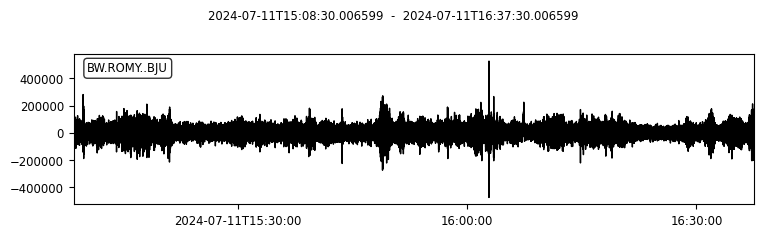

In [8]:
# stt =  read(root_path+f"/Downloads/mseed/30min/ROMY_BJU_{date}.mseed")
stt = read(root_path+f"/Downloads/mseed/ROMY_BJU_{date}.mseed")
# stt =  read(root_path+f"/Downloads/mseed/ROMY_BJU_{date}.mseed", starttime=tbeg, endtime=tend)

stt = stt.detrend("linear")


t1 = stt[0].stats.starttime
t2 = stt[0].stats.endtime

stt = stt.trim(t1+cut_sec, t2-cut_sec)

stt.plot();

### Test Sine Fit Stream

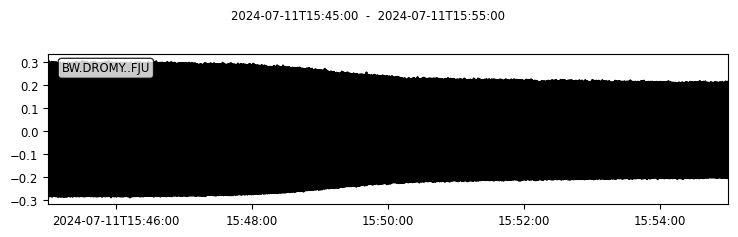

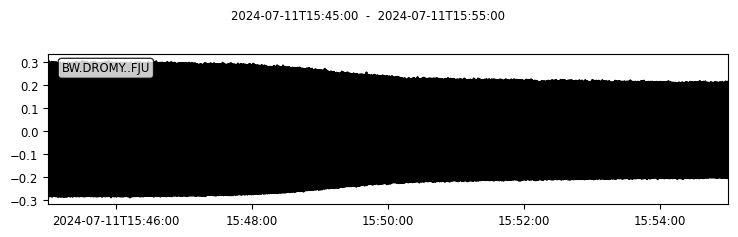

In [9]:
st = st.trim(UTCDateTime("2024-07-11 15:45"), UTCDateTime("2024-07-11 15:55"))
st = st.detrend("demean")
st.plot()

In [10]:
# stx = __sine_fit_stream(st, "BW.ROMY..BJU", Tinterval=1, Toverlap=0.8, plot=True)

In [11]:
# fmin, fmax = 0.001, 0.1

# stt = stt.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)
# stx = stx.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)


In [12]:
# def __compare(st1, st2):

#     from obspy.signal.cross_correlation import correlate, xcorr_max
#     from numpy import nan_to_num, arange, array, linspace, imag, roll, nan
#     from scipy.signal import hilbert
#     from matplotlib.gridspec import GridSpec
#     from submodules.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
#     from submodules.get_fft import __get_fft

#     dt = st1[0].stats.delta

#     tscale, tunit = 1/60, "min"

#     times = st1[0].times()*tscale

#     arr1 = st1.select(channel="FJU")[0].data
#     arr2 = st2.select(channel="BJU")[0].data

#     arr1 /= max(abs(arr1))
#     arr2 /= max(abs(arr2))

#     Nshift = len(arr1)

#     ccf = correlate(arr1, arr2, shift=Nshift, demean=False, normalize='naive', method='fft')

#     cclags = arange(-Nshift, Nshift+1) * dt

#     shift, value = xcorr_max(ccf)

#     arr2_shifted = roll(arr2, shift)

#     print("Nshift: ", shift, "Tshift: ", shift*dt, "CC: ", value)


#     b1, a1 = __compute_orthogonal_distance_regression(arr1, arr2, xerr=None, yerr=None, bx=None, by=None)

#     b1_shifted, a1_shifted = __compute_orthogonal_distance_regression(arr1, arr2_shifted, xerr=None, yerr=None, bx=None, by=None)

#     xxx = linspace(arr1.min(), arr1.max(), 100)


#     res = arr1 - arr2_shifted

#     res[:2*shift] *= nan
#     res[-2*shift:] *= nan

#     spec1, f1, p1 = __get_fft(arr1, dt, window='hann')
#     spec2, f2, p2 = __get_fft(arr2_shifted, dt, window='hann')


#     # ___________________________________________
#     #

#     Nrow, Ncol = 5, 2
#     font = 12

#     fig = plt.figure(figsize=(12, 10))

#     gs0 = GridSpec(Nrow, Ncol, figure=fig, hspace=0.5)
#     gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.2)

#     ax1 = fig.add_subplot(gs[0, :])
#     ax2 = fig.add_subplot(gs[1, :])
#     ax3 = fig.add_subplot(gs[2, :])
#     ax4 = fig.add_subplot(gs0[3, :1])
#     ax5 = fig.add_subplot(gs0[3, 1:])
#     ax6 = fig.add_subplot(gs0[4, :1])
#     ax7 = fig.add_subplot(gs0[4, 1:])

#     plt.subplots_adjust(hspace=0.35)

#     ax1.plot(times, arr1, color="black", label=f"{st1[0].stats.channel}")
#     ax1.set_ylabel("Arb. ()", fontsize=font)
#     # ax1.get_xaxis().set_visible(False)
#     ax1.legend(loc=1)

#     ax2.plot(times, arr2, color="tab:red", label=f"{st2[0].stats.channel}")
#     ax2.legend(loc=1, ncol=1)
#     ax2.set_ylabel("Arb. ()", fontsize=font)

#     ax3.plot(times, res, color="grey", label=f"FJU-BJU")
#     ax3.legend(loc=1, ncol=1)
#     ax3.set_ylabel("Arb. ()", fontsize=font)
#     ax3.set_xlabel(f"Time ({tunit})", fontsize=font, labelpad=1)

#     ax4.scatter(arr1, arr2, color="black", s=2)
#     ax4.plot(xxx, (a1+b1*xxx), ls="--", color="b", label=f"a={a1:.2f}; b={b1:.2f}")
#     ax4.set_xlabel("FJU", fontsize=font)
#     ax4.set_ylabel("BJU", fontsize=font)
#     ax4.legend(loc=4)

#     ax5.scatter(arr1, arr2_shifted, color="black", s=2)
#     ax5.plot(xxx, (a1_shifted+b1_shifted*xxx), ls="--", color="b", label=f"a={a1_shifted:.2f}; b={b1_shifted:.2f}")
#     ax5.set_xlabel("FJU", fontsize=font)
#     ax5.set_ylabel("BJU", fontsize=font)
#     ax5.legend(loc=4)

#     ll = f"t={round(shift*dt, 1)} s  CC={round(value, 5)}"
#     ax6.plot(cclags, ccf, color="k", label=ll)
#     ax6.set_ylabel("CC-Coeff.", fontsize=font)
#     ax6.set_xlabel("Lag time (s)", fontsize=font, labelpad=0)
#     ax6.set_ylim(-1.1, 1.1)
#     ax6.axvline(shift*dt, -1, 1, color="b", ls="--", zorder=0)
#     ax6.scatter(shift*dt, value, color="b", marker="d", zorder=0)
#     ax6.legend()
#     # ax6.text(.005, .97, ll, ha='left', va='top', transform=ax6.transAxes, fontsize=font)

#     ax7.plot(f1, (spec1-spec2), color="k", label=f"FJU-BJU")
#     # ax7.plot(f2, spec2, color="tab:red", label=f"BJU")
#     ax7.set_ylabel("Spec. Amp.", fontsize=font)
#     ax7.set_xlabel("Frequency (Hz)", fontsize=font, labelpad=0)
#     ax7.set_xscale("log")
#     ax7.set_xlim(fmin, fmax)
#     ax7.legend(ncol=2, loc=8)

#     for _k, (ax, ll) in enumerate(zip([ax1, ax2, ax3, ax4, ax5, ax6, ax7], ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)'])):
#         ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)


#     ax1.set_title(f"f = {fmin} - {fmax} Hz")

#     for ax in [ax1, ax2, ax3, ax4, ax5]:
#         ax.grid(ls=":", alpha=0.5, zorder=0, color="grey")

#     plt.show();
#     return fig

# fig = __compare(stx, stt)

# fig.savefig(path_to_figs+f"SP_{date}_{fmin}_{fmax}_comparison.png", format="png", dpi=150, bbox_inches='tight')


## Test Sine Fit

19975 2000000 2500 2400


/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


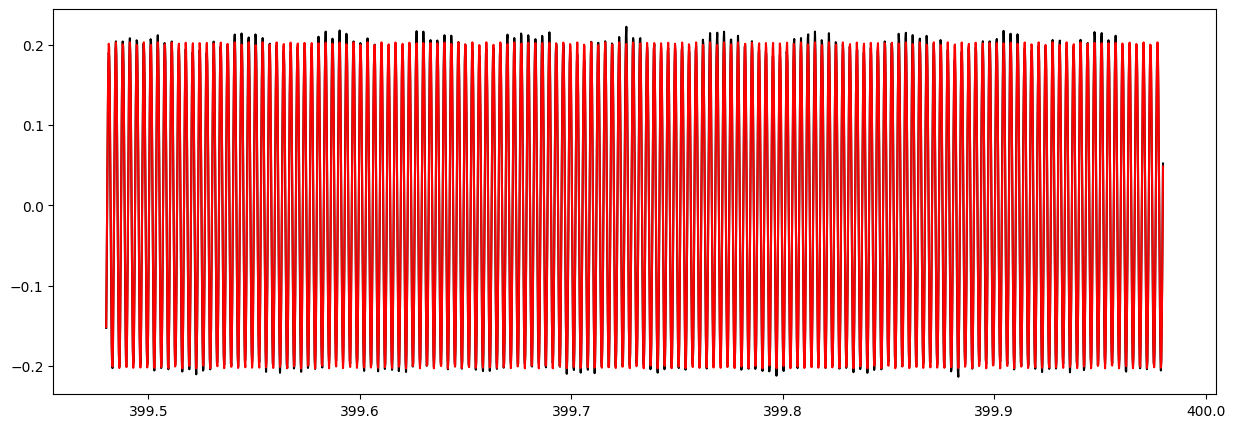

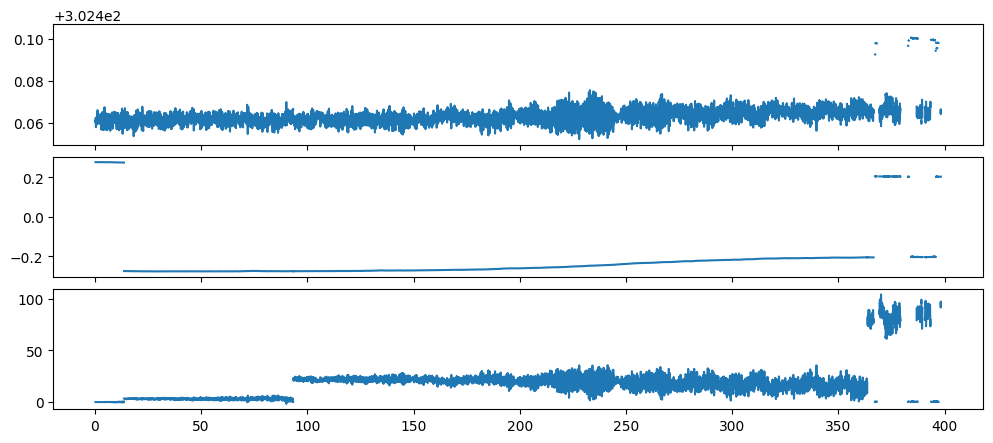

(array([2.5000e-01, 2.7000e-01, 2.9000e-01, ..., 3.9969e+02, 3.9971e+02,
        3.9973e+02]),
 array([302.46045447, 302.46113738, 302.4602275 , ...,          nan,
                 nan,          nan]))

In [16]:
X1, X2 = 0, 2_000_000
test = st[0].data[X1:X2]
time = st[0].times()[X1:X2]

# test = st[0].data
# time = st[0].times()


df = st[0].stats.sampling_rate

tt, freq, amp, pha = __sine_fit(test, time, df, Tinterval=0.5, Toverlap=0.48, plot=True)
tt, freq

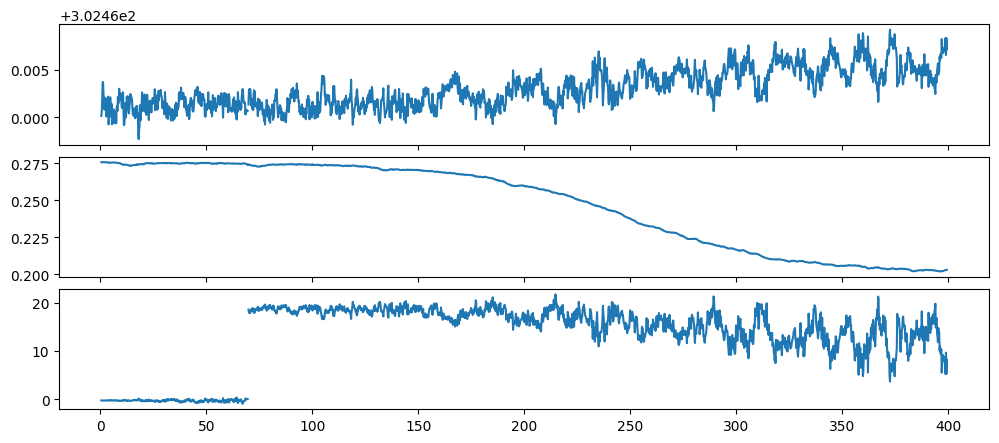

In [18]:
def __makeplot():

    import matplotlib.pyplot as plt

    Nrow, Ncol = 3, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].plot(tt, freq)
    ax[1].plot(tt, amp)
    ax[2].plot(tt, pha)

    # ax.set_xscale("log")

    # ax.set_ylim(0, 8000)

    # ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    plt.show();
    # return fig

fig = __makeplot();

### Test Automatic Script

In [22]:
from andbro__read_sds import __read_sds

In [59]:
def __sine_fit_stream(st_in, seed, Tinterval=1, Toverlap=0.8, plot=True):

    '''
    Fitting a sin-function to the data to estimate an instantaneous frequency
    '''

    import matplotlib.pyplot as plt

    from obspy import Trace, Stream
    from scipy import optimize
    from numpy import sin, hanning, pi, arange, array, diag, zeros, nan, isnan, isinf, pi, inf
    from numpy.linalg import cond
    from scipy.signal import hilbert
    from tqdm.autonotebook import tqdm

    def func(x, a, f, p):
        return a * sin(2 * pi * f * x + p)

    # ring nominal sagnac frequencies
    rings = {"Z":553.5, "U":302.5, "V":447.5, "W":447.5}

    # codes
    net, sta, loc, cha = seed.split('.')

    # to array
    data = st_in[0].data
    times = st_in[0].times()
    starttime = st_in[0].stats.starttime

    # sampling rate
    df = st_in[0].stats.sampling_rate

    # npts per interval
    Nsamples = int(Tinterval*df)
    Noverlap = int(Toverlap*df)

    # npts in data
    Ndata = data.size

    # create time reference
    tt = times

    # amount of windows
    Nwin = 0
    x2 = Nsamples
    while x2 < Ndata:
        x2 = x2 + Nsamples - Noverlap
        Nwin += 1

    # print(Nwin, Ndata, Nsamples, Noverlap)

    # prepare arrays
    amps = zeros(Nwin)*nan
    freq = zeros(Nwin)*nan
    phas = zeros(Nwin)*nan
    time = zeros(Nwin)*nan
    cfs = zeros(Nwin)*nan
    cas = zeros(Nwin)*nan

    # initial values
    a00 = 0.9
    f00 = rings[cha[-1]]
    p00 = 0

    # specify start indices
    # n1, n2 = 0, int(Nsamples - Noverlap)
    n1, n2 = 0, Nsamples

    # fail counter
    fails = 0

    # looping
    for _win in tqdm(range(Nwin)):

        # set start values at begin
        if _win == 0:
            a0, f0, p0 = a00, f00, p00

        # cut data for interval
        _time = tt[n1:n2]
        _data = data[n1:n2]

        # scale by envelope
        env = abs(hilbert(_data)) + 0.001
        _data = _data / env

        # slightly change start values using round
        # a0, f0, p0 = round(a0, 1), round(f0, 1), round(p0, 1)

        # reset start values if nan
        if isnan(a0) or isnan(f0) or isnan(p0):
            a0, f0, p0 = a00, f00, p00

        if isinf(a0) or isinf(f0) or isinf(p0):
            a0, f0, p0 = a00, f00, p00

        a0, f0, p0 = a00, f00, p00

        # fit sine to data
        try:
            params, params_covariance = optimize.curve_fit(func,
                                                           _time,
                                                           _data,
                                                           p0=[a0, f0, p0],
                                                           check_finite=True,
                                                           # x_scale=[1, 100, 1],
                                                           # bounds=([-2, f00-1, -inf],[2, f00+1, inf]),
                                                           # method="trf",
                                                          )
            a0 = params[0]
            f0 = params[1]
            p0 = params[2]

            ca, cf = diag(params_covariance)[0], diag(params_covariance)[1]

        except Exception as e:
            # print(e)
            print(cond(params_covariance))
            fails += 1
            f0, a0, p0, cf, ca = nan, nan, nan, nan, nan

        # if cf > 0.001:
        #     f0, a0, p0 = nan, nan, nan

        # append values
        amps[_win] = a0
        freq[_win] = f0
        phas[_win] = p0
        time[_win] = (tt[n2]-tt[n1])/2 + tt[n1]

        cfs[_win] = cf
        cas[_win] = ca

        # checkup plot for fit
        if plot:
            if _win == Nwin - 1:
                print(f0, a0, p0, cf, ca)
                fig, ax = plt.subplots(1, 1, figsize=(15, 5))

                ax.plot(_time, _data, color='black')

                ax.plot(_time, func(_time, params[0], params[1], params[2]), color='red')

                plt.show();

        # update index
        n1 = n1 + Nsamples - Noverlap
        n2 = n2 + Nsamples - Noverlap

    # checkup plot
    if plot:

        Nrow, Ncol = 3, 1

        font = 12

        fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

        plt.subplots_adjust(hspace=0.1)

        # ax[0].errorbar(time, freq, cfs)
        # ax[1].errorbar(time, amps, cas)
        ax[0].plot(time, freq)
        ax[1].plot(time, amps)
        ax[2].plot(time, phas)

        plt.show();

    def streamout(dat, ll):
        tr_out = Trace()
        tr_out.data = dat
        tr_out.stats.network = net
        tr_out.stats.station = sta
        tr_out.stats.location = ll
        tr_out.stats.channel = cha
        tr_out.stats.starttime = starttime + (Tinterval-Toverlap)
        tr_out.stats.delta = (Tinterval-Toverlap)
        return Stream(tr_out)

    print(f" -> fails: {fails}")

    st_out_f = streamout(freq, "60")
    st_out_p = streamout(phas, "70")

    return st_out_f, st_out_p

In [60]:
def __sine_fit_stream_noP(st_in, seed, Tinterval=1, Toverlap=0.8, plot=True):

    '''
    Fitting a sin-function to the data to estimate an instantaneous frequency
    '''

    import matplotlib.pyplot as plt

    from obspy import Trace, Stream
    from scipy import optimize
    from numpy import sin, hanning, pi, arange, array, diag, zeros, nan, isnan, isinf, pi, inf
    from scipy.signal import hilbert

    from tqdm.autonotebook import tqdm

    def func(x, a, f, p):
        return a * sin(2 * pi * f * x)

    # ring nominal sagnac frequencies
    rings = {"Z":553.5, "U":302.5, "V":447.5, "W":447.5}

    # codes
    net, sta, loc, cha = seed.split('.')

    # to array
    data = st_in[0].data
    times = st_in[0].times()
    starttime = st_in[0].stats.starttime

    # sampling rate
    df = st_in[0].stats.sampling_rate

    # npts per interval
    Nsamples = int(Tinterval*df)
    Noverlap = int(Toverlap*df)

    # npts in data
    Ndata = data.size

    # create time reference
    tt = times

    # amount of windows
    Nwin = 0
    x2 = Nsamples
    while x2 < Ndata:
        x2 = x2 + Nsamples - Noverlap
        Nwin += 1

    # print(Nwin, Ndata, Nsamples, Noverlap)

    # prepare arrays
    amps = zeros(Nwin)*nan
    freq = zeros(Nwin)*nan
    phas = zeros(Nwin)*nan
    time = zeros(Nwin)*nan
    cfs = zeros(Nwin)*nan
    cas = zeros(Nwin)*nan

    # initial values
    a00 = 0.9
    f00 = rings[cha[-1]]
    p00 = 0

    # specify start indices
    # n1, n2 = 0, int(Nsamples - Noverlap)
    n1, n2 = 0, Nsamples

    # fail counter
    fails = 0

    # looping
    for _win in tqdm(range(Nwin)):

        # set start values at begin
        if _win == 0:
            a0, f0, p0 = a00, f00, p00

        # cut data for interval
        _time = tt[n1:n2]
        _data = data[n1:n2]

        # scale by envelope
        env = abs(hilbert(_data)) + 0.001
        _data = _data / env

        # slightly change start values using round
        # a0, f0, p0 = round(a0, 1), round(f0, 1), round(p0, 1)

        # reset start values if nan
        if isnan(a0) or isnan(f0) or isnan(p0):
            a0, f0, p0 = a00, f00, p00

        if isinf(a0) or isinf(f0) or isinf(p0):
            a0, f0, p0 = a00, f00, p00

        a0, f0, p0 = a00, f00, p00

        # fit sine to data
        try:
            params, params_covariance = optimize.curve_fit(func,
                                                           _time,
                                                           _data,
                                                           p0=[a0, f0],
                                                           check_finite=True,
                                                           # x_scale=[1, 100, 1],
                                                           # bounds=([-2, f00-1, -inf],[2, f00+1, inf]),
                                                           # method="trf",
                                                          )
            a0 = params[0]
            f0 = params[1]

            ca, cf = diag(params_covariance)[0], diag(params_covariance)[1]

        except Exception as e:
            # print(e)
            fails += 1
            f0, a0, p0, cf, ca = nan, nan, nan, nan, nan

        # if cf > 0.001:
        #     f0, a0, p0 = nan, nan, nan

        # append values
        amps[_win] = a0
        freq[_win] = f0
        phas[_win] = p0
        time[_win] = (tt[n2]-tt[n1])/2 + tt[n1]

        cfs[_win] = cf
        cas[_win] = ca

        # checkup plot for fit
        if plot:
            if _win == Nwin - 1:
                print(f0, a0, p0, cf, ca)
                fig, ax = plt.subplots(1, 1, figsize=(15, 5))

                ax.plot(_time, _data, color='black')

                ax.plot(_time, func(_time, params[0], params[1]), color='red')

                plt.show();

        # update index
        n1 = n1 + Nsamples - Noverlap
        n2 = n2 + Nsamples - Noverlap

    print(f" -> fails: {fails} of {Nwin} ({fails/Nwin*100}%)")

    # checkup plot
    if plot:

        Nrow, Ncol = 3, 1

        font = 12

        fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

        plt.subplots_adjust(hspace=0.1)

        # ax[0].errorbar(time, freq, cfs)
        # ax[1].errorbar(time, amps, cas)
        ax[0].plot(time, freq)
        ax[1].plot(time, amps)
        ax[2].plot(time, phas)

        plt.show();

    def streamout(dat, ll):
        tr_out = Trace()
        tr_out.data = dat
        tr_out.stats.network = net
        tr_out.stats.station = sta
        tr_out.stats.location = ll
        tr_out.stats.channel = cha
        tr_out.stats.starttime = starttime + (Tinterval-Toverlap)
        tr_out.stats.delta = (Tinterval-Toverlap)
        return Stream(tr_out)


    st_out_f = streamout(freq, "60")
    st_out_p = streamout(phas, "70")

    return st_out_f, st_out_p

In [61]:
def __sine_fit_stream_noA(st_in, seed, Tinterval=1, Toverlap=0.8, plot=True):

    '''
    Fitting a sin-function to the data to estimate an instantaneous frequency
    '''

    import matplotlib.pyplot as plt

    from obspy import Trace, Stream
    from scipy import optimize
    from numpy import sin, hanning, pi, arange, array, diag, zeros, nan, isnan, isinf, pi, inf
    from scipy.signal import hilbert
    from tqdm.autonotebook import tqdm

    def func(x, f, p):
        return sin(2 * pi * f * x + p)

    # ring nominal sagnac frequencies
    rings = {"Z":553.5, "U":302.5, "V":447.5, "W":447.5}

    # codes
    net, sta, loc, cha = seed.split('.')

    # to array
    data = st_in[0].data
    times = st_in[0].times()
    starttime = st_in[0].stats.starttime

    # sampling rate
    df = st_in[0].stats.sampling_rate

    # npts per interval
    Nsamples = int(Tinterval*df)
    Noverlap = int(Toverlap*df)

    # npts in data
    Ndata = data.size

    # create time reference
    tt = times

    # amount of windows
    Nwin = 0
    x2 = Nsamples
    while x2 < Ndata:
        x2 = x2 + Nsamples - Noverlap
        Nwin += 1

    # print(Nwin, Ndata, Nsamples, Noverlap)

    # prepare arrays
    amps = zeros(Nwin)*nan
    freq = zeros(Nwin)*nan
    phas = zeros(Nwin)*nan
    time = zeros(Nwin)*nan
    cfs = zeros(Nwin)*nan
    cas = zeros(Nwin)*nan

    # initial values
    a00 = 0.9
    f00 = rings[cha[-1]]
    p00 = 0

    # specify start indices
    # n1, n2 = 0, int(Nsamples - Noverlap)
    n1, n2 = 0, Nsamples

    # fail counter
    fails = 0

    # looping
    for _win in tqdm(range(Nwin)):

        # set start values at begin
        if _win == 0:
            a0, f0, p0 = a00, f00, p00

        # cut data for interval
        _time = tt[n1:n2]
        _data = data[n1:n2]

        # scale by envelope
        env = abs(hilbert(_data)) + 0.001
        _data = _data / env

        # slightly change start values using round
        # a0, f0, p0 = round(a0, 1), round(f0, 1), round(p0, 1)

        # reset start values if nan
        if isnan(a0) or isnan(f0) or isnan(p0):
            a0, f0, p0 = a00, f00, p00

        if isinf(a0) or isinf(f0) or isinf(p0):
            a0, f0, p0 = a00, f00, p00

        # a0, f0, p0 = a00, f00, p00

        # fit sine to data
        try:
            params, params_covariance = optimize.curve_fit(func,
                                                           _time,
                                                           _data,
                                                           p0=[f0, p0],
                                                           check_finite=True,
                                                           # bounds=([-2, f00-1, -inf],[2, f00+1, inf]),
                                                           # method="trf",
                                                          )
            f0 = params[0]
            p0 = params[1]

            cf, cp = diag(params_covariance)[0], diag(params_covariance)[1]

        except Exception as e:
            # print(e)
            fails += 1
            # f0, a0, p0, cf, ca = nan, nan, nan, nan, nan

        if cf > 0.001:
            f0, a0, p0 = nan, nan, nan

        # append values
        amps[_win] = a0
        freq[_win] = f0
        phas[_win] = p0
        time[_win] = (tt[n2]-tt[n1])/2 + tt[n1]

        cfs[_win] = cf

        # checkup plot for fit
        if plot:
            if _win == Nwin - 1:
                print(f0, a0, p0, cf, cp)
                fig, ax = plt.subplots(1, 1, figsize=(15, 5))

                ax.plot(_time, _data, color='black')

                ax.plot(_time, func(_time, params[0], params[1]), color='red')

                plt.show();

        # update index
        n1 = n1 + Nsamples - Noverlap
        n2 = n2 + Nsamples - Noverlap

    # checkup plot
    if plot:

        Nrow, Ncol = 3, 1

        font = 12

        fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

        plt.subplots_adjust(hspace=0.1)

        # ax[0].errorbar(time, freq, cfs)
        # ax[1].errorbar(time, amps, cas)
        ax[0].plot(time, freq)
        ax[1].plot(time, amps)
        ax[2].plot(time, phas)

        plt.show();

    def streamout(dat, ll):
        tr_out = Trace()
        tr_out.data = dat
        tr_out.stats.network = net
        tr_out.stats.station = sta
        tr_out.stats.location = ll
        tr_out.stats.channel = cha
        tr_out.stats.starttime = starttime + (Tinterval-Toverlap)
        tr_out.stats.delta = (Tinterval-Toverlap)
        return Stream(tr_out)

    print(f" -> fails: {fails}")

    st_out_f = streamout(freq, "60")
    st_out_p = streamout(phas, "70")

    return st_out_f, st_out_p

In [ ]:
stf, stp = __sine_fit_stream(st, "BW.ROMY..BJU", Tinterval=1, Toverlap=0.8, plot=True)

  0%|          | 0/35996 [00:00<?, ?it/s]

/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [17]:
def __get_time_intervals(tbeg, tend, interval_seconds, interval_overlap):

    from obspy import UTCDateTime

    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    times = []

    t1, t2 = tbeg, tbeg + interval_seconds
    while t2 <= tend:
        times.append((t1, t2))
        t1 = t1 + interval_seconds - interval_overlap
        t2 = t2 + interval_seconds - interval_overlap

    return times

In [23]:
path_to_archive = archive_path+"romy_archive/"

path_to_out_file = "/home/brotzer/Downloads/tmp/output/"

t1 = UTCDateTime("2024-07-11 15:30")
t2 = UTCDateTime("2024-07-11 16:00")

interval_seconds = 600

interval_overlap = 0

times = __get_time_intervals(t1, t2, interval_seconds, interval_overlap)

2024-07-11T15:30:00.000000Z 2024-07-11T15:40:00.000000Z
0.9 302.5 0 7.069783016099749e-06 3.811582418467381e-08
0.9 302.5 0 7.260795940951561e-06 3.9062249096825785e-08
0.9 302.5 0 8.150418994868982e-06 4.3151506872979905e-08
0.9 302.5 0 8.08847937716896e-06 4.2523250242205395e-08
0.9 302.5 0 7.829847149736082e-06 3.9674293903563144e-08
0.9 302.5 0 7.1120940003216255e-06 3.59403886562767e-08
0.9 302.5 0 7.395652457879572e-06 3.72828801374818e-08
0.9 302.5 0 7.690963596204464e-06 3.8699641178301644e-08
0.9 302.5 0 7.427866179335758e-06 3.7300077363137084e-08
0.9 302.5 0 7.4275263332024275e-06 3.71426578675932e-08
0.9 302.5 0 8.228034013255962e-06 4.0930000814586705e-08
0.9 302.5 0 8.228034013255962e-06 4.0930000814586705e-08
0.9 302.5 0 8.148369086229706e-06 4.044990755118391e-08
0.9 302.5 0 7.95730853880591e-06 3.944183693378665e-08
0.9 302.5 0 6.875614887082546e-06 3.406840126188581e-08
0.9 302.5 0 9.349185733837059e-06 4.503655691627659e-08
0.9 302.5 0 8.897058064955069e-06 4.2625825

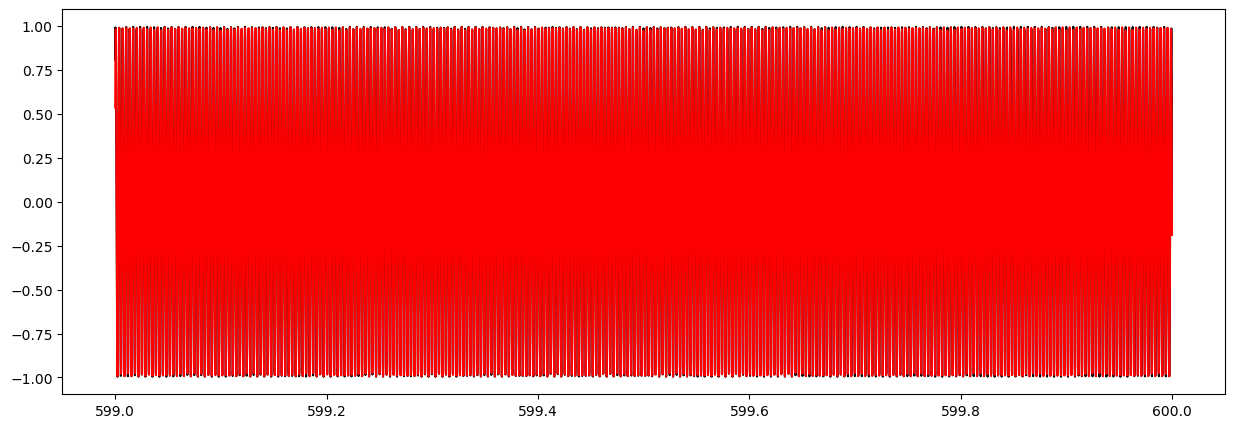

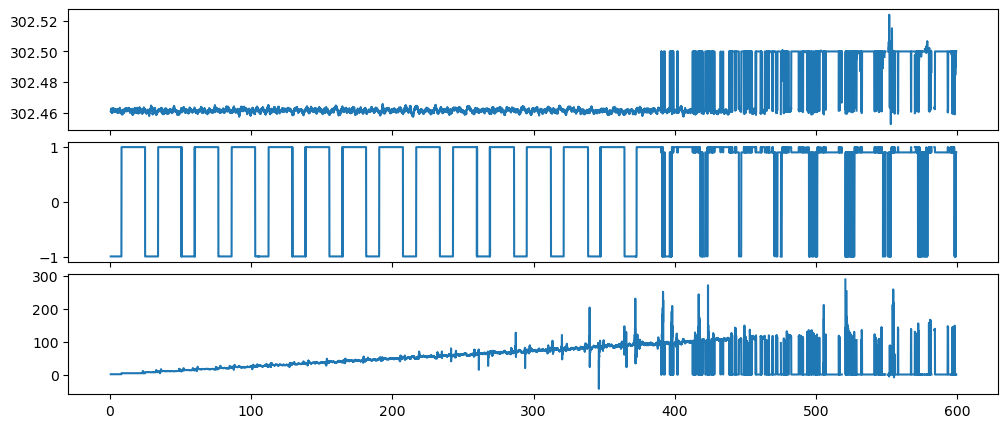

 -> fails: 2709
1 Trace(s) in Stream:
BW.ROMY.60.BJU | 2024-07-11T15:30:00.050000Z - 2024-07-11T15:39:59.050000Z | 20.0 Hz, 11981 samples
2024-07-11T15:40:00.000000Z 2024-07-11T15:50:00.000000Z


KeyboardInterrupt: 

In [31]:
stfout = Stream()
stpout = Stream()

for _t1, _t2 in times:

    print(_t1, _t2)

    st00 = __read_sds(path_to_archive, "BW.DROMY..FJU", _t1, _t2)

    # convert to volt
    for tr in st00:
        tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

    # remove trend
    st00 = st00.detrend("linear")
    # st00 = st00.taper(0.01)
    # st00 = st00.filter("bandpass", freqmin=fsagnac-fband, freqmax=fsagnac+fband, corners=4, zerophase=True)

    stf, stp = __sine_fit_stream(st00, "BW.ROMY..BJU", Tinterval=1, Toverlap=0.95, plot=True)

    print(stf)

    stfout += stf
    stpout += stp

    # stx.write(path_to_out_file+f"tmp_{stx[0].starttime}.mseed")


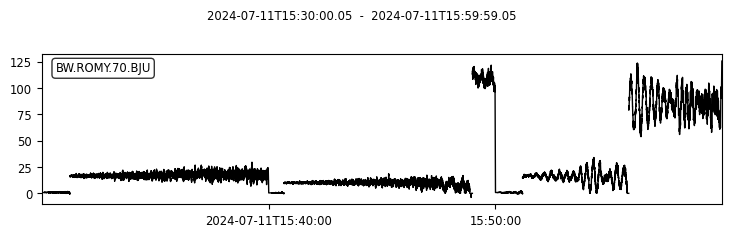

1 Trace(s) in Stream:
BW.ROMY.70.BJU | 2024-07-11T15:30:00.050000Z - 2024-07-11T15:59:59.050000Z | 20.0 Hz, 35981 samples

In [25]:
stpout.merge(fill_value="interpolate").plot()
stpout

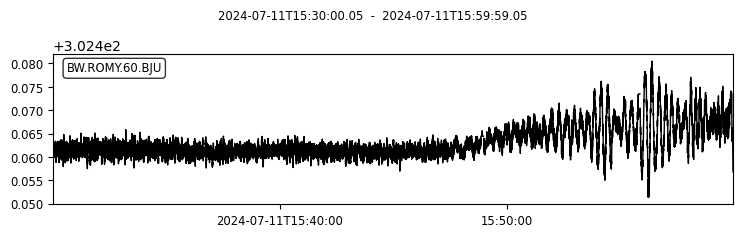

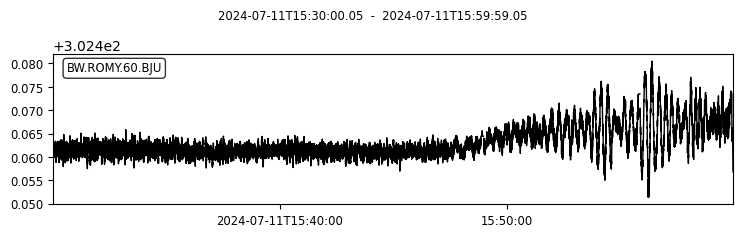

In [26]:
stfout.merge().plot()